# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque , namedtuple

import random

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app",worker_id=2)


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)



Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break

# print("Score: {}".format(score))


When finished, you can close the environment.

In [6]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
class Network(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=128):
        """
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Network, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)


    """
    ###################################################
    Build a network that maps state -> action values.
    """
    def forward(self, state):

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [7]:
# # test network with random state input

# y = torch.tensor(np.random.rand(state_size),dtype = torch.float)
# model(y)

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 2e-3              # for soft update of target parameters
LR = 1e-3               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("device:",device)
class Agent():
 
    def __init__(self, state_size, action_size, seed):
        
#         BUFFER_SIZE = int(1e5)  # replay buffer size
#         BATCH_SIZE = 64         # minibatch size
#         GAMMA = 0.99            # discount factor
#         TAU = 1e-3              # for soft update of target parameters
#         LR = 5e-4               # learning rate 
#         UPDATE_EVERY = 4        # how often to update the network
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = np.random.seed(seed)
        
        self.buffer_size = BUFFER_SIZE
        self.batch_size = BATCH_SIZE

        # define two Q_networks local (taking actions) and target (updating local)
        self.qnetwork_local = Network(state_size,action_size,seed).to(device)
        self.qnetwork_target = Network(state_size,action_size,seed).to(device)
        # define optimizer to minimise loss by updating local net
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr = LR)
        
        # define replay memory
        self.memory = ReplayBuffer(self.action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    
    def act(self, state, eps):

        '''
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        '''
        
        # make state tensor -> convert to float -> add dim of size 1 at pos 0 -> send to device
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval() # set to evaluation mode
        with torch.no_grad(): # without tracking gradients
            action_values = self.qnetwork_local(state) # get the action values
        self.qnetwork_local.train() # set to training mode
        
        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
        
    
    def step(self, state, action, reward, next_state, done):
        # save experiences in replay memory for experience sampling
        self.memory.add(state, action, reward, next_state, done)
        
        # learn every few time steps
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences,GAMMA)
                
    def learn(self, experiences, GAMMA):
        ''' Update value parameters using given batch of expereince tuples
        
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        '''
        # unpack experiences in to sarsd
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values (for next states) from target model
        # get action from target net -> detach gradient -> get max value -> add dim 1 at pos 1
        Q_targets_next = self.qnetwork_target(next_states.float()).detach().max(1)[0].unsqueeze(1) # might have a bug here poss here max(1)[1] or max(0)[0]
        
        # for double dqn
#         output = self.qnetwork_local(next_states.float()).detach()
#         values, indices = self.qnetwork_local(next_states.float()).detach().max(1)
#         indices = indices.unsqueeze(1)
#         Q_targets_next = output.gather(1,indices)

        
        # Compute Q targets for current states
        Q_targets = rewards + (GAMMA*Q_targets_next*(1-dones))
        
        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1,actions)
        
        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)
        
        
    def soft_update(self, local_model, target_model,tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(),local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



device: cpu


In [9]:
class ReplayBuffer():
    ''' buffer to store experience for DQN'''
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state,action,reward,next_state,done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""

        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


Episode 100	Average Score: 1.33	 Epsilon: 0.61
Episode 200	Average Score: 3.80	 Epsilon: 0.37
Episode 300	Average Score: 7.28	 Epsilon: 0.22
Episode 400	Average Score: 9.52	 Epsilon: 0.13
Episode 500	Average Score: 12.24	 Epsilon: 0.08
Episode 600	Average Score: 12.92	 Epsilon: 0.05
Episode 700	Average Score: 13.22	 Epsilon: 0.05
Episode 800	Average Score: 12.84	 Epsilon: 0.05
Episode 898	Average Score: 14.03	 Epsilon: 0.05
Environment solved in 798 episodes!	Average Score: 14.03


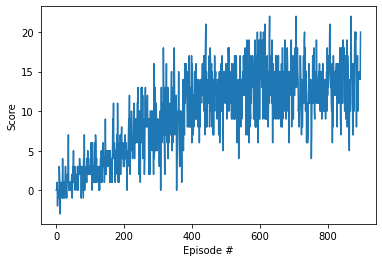

In [11]:
seed = 0
scores_average_window = 100
target_score = 14.0

def dqn(n_episodes=3000, max_t=1000, eps_start=1.0, eps_end=0.05, eps_decay=0.995):
    agent = Agent(state_size, action_size, seed)
    scores = []
    scores_window = deque(maxlen = 100)
    eps = eps_start
    for i_episode in range(1,n_episodes+1):
        state = env.reset(train_mode=True)[brain_name]
        state = state.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
#             next_state, reward, dones, _ = env.step(action)
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score) #save most recent score
        scores.append(score)
        average_score = np.mean(scores[i_episode-min(i_episode,scores_average_window):i_episode+1])
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        # print some agent performance info
        print('\rEpisode {}\tAverage Score: {:.2f}\t Epsilon: {:.2f}'.format(i_episode, average_score,eps), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}\t Epsilon: {:.2f}'.format(i_episode,average_score,eps))
        if np.mean(scores_window)>=target_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, average_score,eps))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores, agent

scores, agent = dqn()
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
        


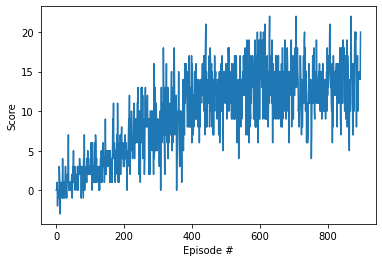

In [12]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
avgScores = moving_average(scores,1)
plt.plot(np.arange(len(avgScores)), avgScores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
        

In [13]:
env_info = env.reset(train_mode=True)[brain_name]
env_info.vector_observations[0]

array([0.        , 1.        , 0.        , 0.        , 0.5323227 ,
       0.        , 0.        , 1.        , 0.        , 0.19732645,
       1.        , 0.        , 0.        , 0.        , 0.40275246,
       0.        , 0.        , 1.        , 0.        , 0.52040213,
       0.        , 0.        , 1.        , 0.        , 0.58148384,
       1.        , 0.        , 0.        , 0.        , 0.65469515,
       0.        , 0.        , 1.        , 0.        , 0.98368764,
       0.        , 0.        ])

In [14]:
device = "cpu"
device

'cpu'

In [17]:
#model = Network()

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    eps = 0.3
    action = agent.act(state, eps)
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))




Score: 11.0


In [11]:
seed = 0
state_dict = torch.load('checkpoint.pth')
model = Network(state_size, action_size,seed)
model.load_state_dict(state_dict)

In [14]:
model.eval()

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    eps = 0.3
    action = model(torch.from_numpy(state))
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break

print("Score: {}".format(score))

RuntimeError: Expected object of type torch.DoubleTensor but found type torch.FloatTensor for argument #2 'mat2'

array([0.        , 1.        , 0.        , 0.        , 0.16895212,
       0.        , 1.        , 0.        , 0.        , 0.20073597,
       1.        , 0.        , 0.        , 0.        , 0.12865657,
       0.        , 1.        , 0.        , 0.        , 0.14938059,
       1.        , 0.        , 0.        , 0.        , 0.58185619,
       0.        , 1.        , 0.        , 0.        , 0.16089135,
       0.        , 1.        , 0.        , 0.        , 0.31775284,
       0.        , 0.        ])